# IMPORT LIBRARIES & DATASET

In [1]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_profiling
%matplotlib inline

In [2]:
# read csv file
df_OR = pd.read_csv('C:/Users/Reshm/Desktop/warehouse/Online_retail_data.csv')

In [3]:
df_OR.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [4]:
df_OR.shape

(541909, 8)

In [5]:
df_OR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
df_OR.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

# ELIMINATING REDUNDANT VARIABLES

In [7]:
conn = sqlite3.connect("RFMdb")
cur = conn.cursor() 

In [8]:
cur.execute("drop table data")

In [9]:
# load CRM data into the RFMdb database
df_OR.to_sql("data", conn)

In [10]:
# CHECK IF DATA INSERTED INTO data/RFMdb
df_Fact = pd.read_sql('SELECT * FROM data', conn)
df_Fact

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/2010 08:26,2.55,17850.0,United Kingdom
1,1,536365,71053,WHITE METAL LANTERN,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
2,2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/2010 08:26,2.75,17850.0,United Kingdom
3,3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
4,4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...,...
541904,541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,09/12/2011 12:50,0.85,12680.0,France
541905,541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,09/12/2011 12:50,2.10,12680.0,France
541906,541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,09/12/2011 12:50,4.15,12680.0,France
541907,541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,09/12/2011 12:50,4.15,12680.0,France


In [11]:
# clean data and group transactions by Customerid
clean_data= pd.read_sql(''' SELECT customerID,
                   MAX(InvoiceDate) AS last_order_date,
                   COUNT(*) AS Frequency,
                   SUM(Unitprice*Quantity) AS Amount
            FROM data
            WHERE InvoiceNo NOT LIKE '%C%'
            AND customerId IS NOT NULL
            AND unitprice != 0
            GROUP BY customerId ''', conn
                      )

In [12]:
clean_data

df_OR['InvoiceDate'] = pd.to_datetime(df_OR['InvoiceDate'],format='%d/%m/%Y %H:%M')
max_date = max(df_OR['InvoiceDate'])
df_OR['Diff'] = max_date - df_OR['InvoiceDate']
rfm_ds = df_OR.groupby('CustomerID')['Diff'].min()
r=df_OR.groupby('CustomerID')['Diff'].min()
rfm_ds= rfm_ds.reset_index()
rfm_ds.columns = ['CustomerID','Diff']
rfm_ds['Recency'] = rfm_ds['Diff'].dt.days
print(rfm_ds)

      CustomerID              Diff  Recency
0        12346.0 325 days 02:33:00      325
1        12347.0   1 days 20:58:00        1
2        12348.0  74 days 23:37:00       74
3        12349.0  18 days 02:59:00       18
4        12350.0 309 days 20:49:00      309
...          ...               ...      ...
4367     18280.0 277 days 02:58:00      277
4368     18281.0 180 days 01:57:00      180
4369     18282.0   7 days 01:07:00        7
4370     18283.0   3 days 00:48:00        3
4371     18287.0  42 days 03:21:00       42

[4372 rows x 3 columns]


In [13]:
clean_data=pd.merge(rfm_ds,clean_data,on='CustomerID',how='inner')

In [14]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4338 entries, 0 to 4337
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype          
---  ------           --------------  -----          
 0   CustomerID       4338 non-null   float64        
 1   Diff             4338 non-null   timedelta64[ns]
 2   Recency          4338 non-null   int64          
 3   last_order_date  4338 non-null   object         
 4   Frequency        4338 non-null   int64          
 5   Amount           4338 non-null   float64        
dtypes: float64(2), int64(2), object(1), timedelta64[ns](1)
memory usage: 237.2+ KB


# REMOVING OUTLIERS

In [15]:
#removing outliers
Q1 = clean_data.Amount.quantile(0.05)
Q3 = clean_data.Amount.quantile(0.95)
IQR = Q3 - Q1
clean_data = clean_data[(clean_data.Amount >= Q1 - 1.5*IQR) & (clean_data.Amount <= Q3 + 1.5*IQR)]

Q1 = clean_data.Recency.quantile(0.05)
Q3 = clean_data.Recency.quantile(0.95)
IQR = Q3 - Q1
clean_data = clean_data[(clean_data.Recency >= Q1 - 1.5*IQR) & (clean_data.Recency <= Q3 + 1.5*IQR)]

Q1 = clean_data.Frequency.quantile(0.05)
Q3 = clean_data.Frequency.quantile(0.95)
IQR = Q3 - Q1
clean_data = clean_data[(clean_data.Frequency >= Q1 - 1.5*IQR) & (clean_data.Frequency <= Q3 + 1.5*IQR)]

In [16]:
clean_data

,CustomerID,Diff,Recency,last_order_date,Frequency,Amount
1,12347.0,1 days 20:58:00,1,31/10/2011 12:25,182,4310.00
2,12348.0,74 days 23:37:00,74,25/09/2011 13:13,31,1797.24
3,12349.0,18 days 02:59:00,18,21/11/2011 09:51,73,1757.55
4,12350.0,309 days 20:49:00,309,02/02/2011 16:01,17,334.40
5,12352.0,35 days 22:13:00,35,28/09/2011 14:58,85,2506.04
...,...,...,...,...,...,...
4332,18278.0,73 days 00:52:00,73,27/09/2011 11:58,9,173.90
4333,18280.0,277 days 02:58:00,277,07/03/2011 09:52,10,180.60
4334,18281.0,180 days 01:57:00,180,12/06/2011 10:53,7,80.82
4335,18282.0,7 days 01:07:00,7,05/08/2011 13:35,12,178.05


In [17]:
cur.execute("drop table cleaneddata")

# DISTRIBUTION ANALYSIS

E:\anaconda_3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Recency')

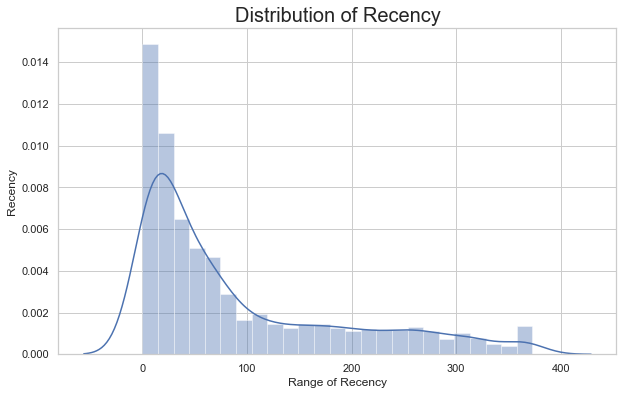

In [18]:
#Distribution of Count_order
plt.figure(figsize=(10,6))
sns.set(style = 'whitegrid')
sns.distplot(clean_data['Recency'])
plt.title('Distribution of Recency', fontsize = 20)
plt.xlabel('Range of Recency')
plt.ylabel('Recency')

In [19]:
clean_data.to_sql("cleaneddata", conn)

E:\anaconda_3\lib\site-packages\pandas\io\sql.py:601: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  pandas_sql.to_sql(


E:\anaconda_3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Frequency')

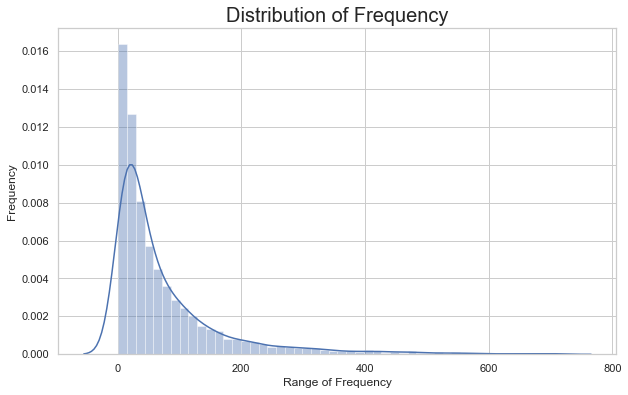

In [20]:
#Distribution of Count_order
plt.figure(figsize=(10,6))
sns.set(style = 'whitegrid')
sns.distplot(clean_data['Frequency'])
plt.title('Distribution of Frequency', fontsize = 20)
plt.xlabel('Range of Frequency')
plt.ylabel('Frequency')

E:\anaconda_3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Amount')

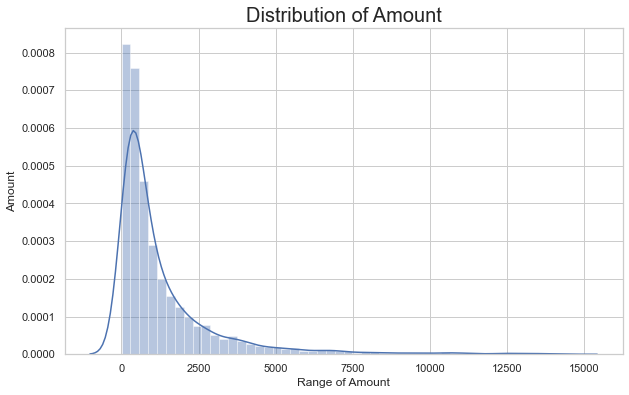

In [21]:
#Distribution of totalprice
plt.figure(figsize=(10, 6))
sns.set(style = 'whitegrid')
sns.distplot(clean_data['Amount'])
plt.title('Distribution of Amount', fontsize = 20)
plt.xlabel('Range of Amount')
plt.ylabel('Amount')

In [22]:
clean_data.describe()

,CustomerID,Diff,Recency,Frequency,Amount
count,4256.000000,4256,4256.000000,4256.000000,4256.000000
mean,15302.110667,91 days 12:06:28.590225564,90.984023,76.516447,1321.507578
std,1721.941368,99 days 10:24:49.254549490,99.431308,98.807378,1816.413409
min,12347.000000,0 days 00:00:00,0.000000,1.000000,3.750000
25%,13812.750000,17 days 00:11:30,17.000000,17.000000,304.415000
50%,15305.000000,50 days 00:52:30,50.000000,40.000000,657.265000
75%,16780.250000,142 days 01:17:45,142.000000,96.000000,1571.285000
max,18287.000000,373 days 02:57:00,373.000000,710.000000,14389.900000


In [49]:
clean_data.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# CORRELATION ANALYSIS

<AxesSubplot:>

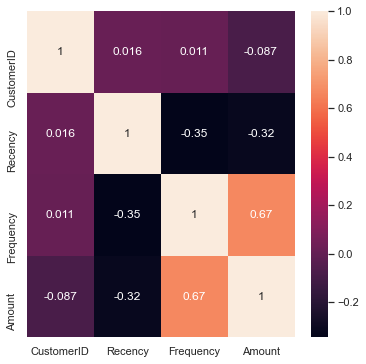

In [23]:
plt.figure(figsize=(6,6))
sns.heatmap(clean_data.corr(), annot = True)

# RFM SEGMENTATION

In [24]:
#clean the data and calculate rfm values
df_Fact = pd.read_sql(''' SELECT customerID,last_order_date,Frequency,Amount,Recency,rfm_recency, rfm_frequency, rfm_monetary, rfm_recency*100 + rfm_frequency*10 + rfm_monetary AS rfm_combined 
    FROM 
     ( SELECT customerid,last_order_date,Frequency,Amount,Recency, 
             NTILE(4) OVER (ORDER BY Recency DESC) AS rfm_recency,
             NTILE(4) OVER (ORDER BY Frequency) AS rfm_frequency,
             NTILE(4) OVER (ORDER BY Amount) AS rfm_monetary
      FROM 
            cleaneddata
            ) 
 ''', conn)

In [47]:
df_Fact

,customerid,last_order_date,Frequency,Amount,Recency,rfm_recency,rfm_frequency,rfm_monetary,rfm_combined,rfm_level,Cluster_Id,Cluster
0,13747.0,01/12/2010 10:37,1,79.60,373,1,1,1,111,Lost,0,0
1,12791.0,01/12/2010 11:27,2,192.60,373,1,1,1,111,Lost,0,0
2,18074.0,01/12/2010 09:53,13,489.60,373,1,1,2,112,Hibernating,0,0
3,16583.0,01/12/2010 12:03,14,233.45,373,1,1,1,111,Lost,0,0
4,17908.0,01/12/2010 11:45,58,243.28,373,1,3,1,131,Lost,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4251,16558.0,31/05/2011 10:45,460,8338.49,0,4,4,4,444,Best Customers,2,2
4252,17315.0,31/08/2011 15:49,473,6292.26,0,4,4,4,444,Best Customers,2,2
4253,14730.0,28/03/2011 12:52,501,2005.06,0,4,4,4,444,Best Customers,2,2
4254,15498.0,27/10/2011 16:22,512,13316.40,0,4,4,4,444,Best Customers,2,2


In [26]:
import pandas as pd
import matplotlib.pyplot as plt

def rfm_level(df_Fact):
    if ((df_Fact['rfm_recency'] >= 4) and (df_Fact['rfm_frequency'] >= 4) 
        and (df_Fact['rfm_monetary'] >= 4)):
        return 'Best Customers'
    elif ((df_Fact['rfm_recency'] >= 3) and (df_Fact['rfm_frequency'] >= 3)
          and (df_Fact['rfm_monetary'] >= 3)):
        return 'Loyal'
    elif ((df_Fact['rfm_recency'] >= 3) and (df_Fact['rfm_frequency'] >= 1)
          and (df_Fact['rfm_monetary'] >= 2)):
        return 'Potential Loyalist'
    elif ((df_Fact['rfm_recency'] >= 3) and (df_Fact['rfm_frequency'] >= 1)
          and (df_Fact['rfm_monetary'] >= 1)):
        return 'Promising'
    elif ((df_Fact['rfm_recency'] >= 2) and (df_Fact['rfm_frequency'] >= 2)
          and (df_Fact['rfm_monetary'] >= 2)):
        return 'Customers Needing Attention'
    elif ((df_Fact['rfm_recency'] >= 1) and (df_Fact['rfm_frequency'] >= 2)
          and (df_Fact['rfm_monetary'] >= 2)):
        return 'At Risk'
    elif ((df_Fact['rfm_recency'] >= 1) and (df_Fact['rfm_frequency'] >= 1)
          and (df_Fact['rfm_monetary'] >= 2)):
        return 'Hibernating'
    else:
        return 'Lost'

In [27]:
df_Fact['rfm_level'] = df_Fact.apply(rfm_level, axis=1)
df_Fact

,customerid,last_order_date,Frequency,Amount,Recency,rfm_recency,rfm_frequency,rfm_monetary,rfm_combined,rfm_level
0,13747.0,01/12/2010 10:37,1,79.60,373,1,1,1,111,Lost
1,12791.0,01/12/2010 11:27,2,192.60,373,1,1,1,111,Lost
2,18074.0,01/12/2010 09:53,13,489.60,373,1,1,2,112,Hibernating
3,16583.0,01/12/2010 12:03,14,233.45,373,1,1,1,111,Lost
4,17908.0,01/12/2010 11:45,58,243.28,373,1,3,1,131,Lost
...,...,...,...,...,...,...,...,...,...,...
4251,16558.0,31/05/2011 10:45,460,8338.49,0,4,4,4,444,Best Customers
4252,17315.0,31/08/2011 15:49,473,6292.26,0,4,4,4,444,Best Customers
4253,14730.0,28/03/2011 12:52,501,2005.06,0,4,4,4,444,Best Customers
4254,15498.0,27/10/2011 16:22,512,13316.40,0,4,4,4,444,Best Customers


In [28]:
# Calculate total customers in each segment
rfm_agg = df_Fact.groupby('rfm_level').agg({'customerid':'count'})
print(rfm_agg)

                             customerid
rfm_level                              
At Risk                             436
Best Customers                      416
Customers Needing Attention         692
Hibernating                         243
Lost                                757
Loyal                               848
Potential Loyalist                  557
Promising                           307


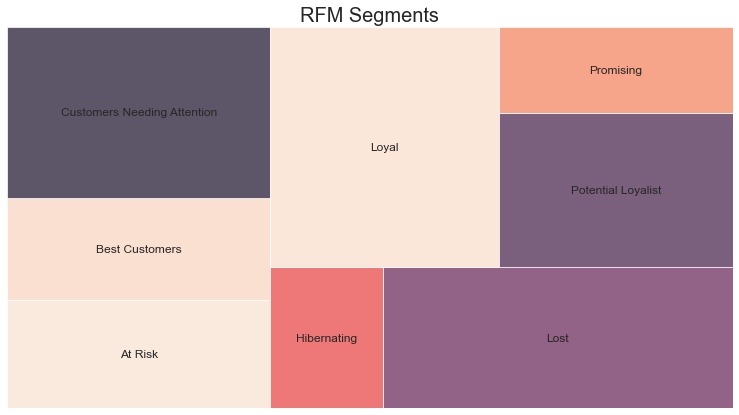

In [29]:
#RFM visualization, you may have to install squarify
import squarify
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(13, 7)
squarify.plot(sizes=rfm_agg['customerid'], 
              label=['At Risk',
                     'Best Customers',
                     'Customers Needing Attention',
                     'Hibernating',
                     'Lost', 
                     'Loyal', 
                     'Potential Loyalist',
                     'Promising'], alpha=0.7)
plt.title("RFM Segments",fontsize=20)
plt.axis('off')
plt.show()

In [30]:
rfm_ds_final=df_Fact
rfm_ds_final

,customerid,last_order_date,Frequency,Amount,Recency,rfm_recency,rfm_frequency,rfm_monetary,rfm_combined,rfm_level
0,13747.0,01/12/2010 10:37,1,79.60,373,1,1,1,111,Lost
1,12791.0,01/12/2010 11:27,2,192.60,373,1,1,1,111,Lost
2,18074.0,01/12/2010 09:53,13,489.60,373,1,1,2,112,Hibernating
3,16583.0,01/12/2010 12:03,14,233.45,373,1,1,1,111,Lost
4,17908.0,01/12/2010 11:45,58,243.28,373,1,3,1,131,Lost
...,...,...,...,...,...,...,...,...,...,...
4251,16558.0,31/05/2011 10:45,460,8338.49,0,4,4,4,444,Best Customers
4252,17315.0,31/08/2011 15:49,473,6292.26,0,4,4,4,444,Best Customers
4253,14730.0,28/03/2011 12:52,501,2005.06,0,4,4,4,444,Best Customers
4254,15498.0,27/10/2011 16:22,512,13316.40,0,4,4,4,444,Best Customers


# K MEANS

In [31]:
from sklearn.preprocessing import MinMaxScaler
X = rfm_ds_final[['Amount', 'Frequency', 'Recency','rfm_combined']]
scaler = MinMaxScaler()
rfm_ds_scaled = scaler.fit_transform(X)

In [32]:
rfm_ds_scaled = pd.DataFrame(rfm_ds_scaled)
rfm_ds_scaled.columns = ['Amount', 'Frequency', 'Recency','rfm_combined']
rfm_ds_scaled.head()

,Amount,Frequency,Recency,rfm_combined
0,0.005272,0.000000,1.0,0.000000
1,0.013127,0.001410,1.0,0.000000
2,0.033772,0.016925,1.0,0.003003
3,0.015967,0.018336,1.0,0.000000
4,0.016650,0.080395,1.0,0.060060


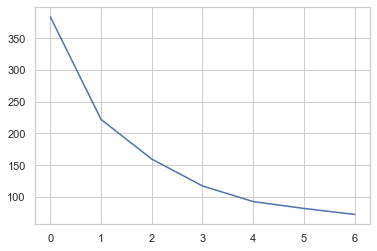

In [33]:
#wss
#silhouette score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
wss = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_ds_scaled)
    wss.append(kmeans.inertia_)
    
plt.plot(wss)

In [34]:
#silhouette score
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_ds_scaled)
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(rfm_ds_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.5302441717951525
For n_clusters=3, the silhouette score is 0.49554390557320077
For n_clusters=4, the silhouette score is 0.5037838807527304
For n_clusters=5, the silhouette score is 0.5489008952841442
For n_clusters=6, the silhouette score is 0.5336837192575962
For n_clusters=7, the silhouette score is 0.5343846422151612
For n_clusters=8, the silhouette score is 0.5338066078996079


In [35]:
#model creation
kmeans = KMeans(n_clusters=5, max_iter=50)
kmeans.fit(rfm_ds_scaled)
lbs = kmeans.labels_
print(kmeans.labels_)

[0 0 0 ... 2 2 2]


In [38]:
rfm_ds_final['Cluster'] = lbs
rfm_ds_final

,customerid,last_order_date,Frequency,Amount,Recency,rfm_recency,rfm_frequency,rfm_monetary,rfm_combined,rfm_level,Cluster_Id,Cluster
0,13747.0,01/12/2010 10:37,1,79.60,373,1,1,1,111,Lost,0,0
1,12791.0,01/12/2010 11:27,2,192.60,373,1,1,1,111,Lost,0,0
2,18074.0,01/12/2010 09:53,13,489.60,373,1,1,2,112,Hibernating,0,0
3,16583.0,01/12/2010 12:03,14,233.45,373,1,1,1,111,Lost,0,0
4,17908.0,01/12/2010 11:45,58,243.28,373,1,3,1,131,Lost,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4251,16558.0,31/05/2011 10:45,460,8338.49,0,4,4,4,444,Best Customers,2,2
4252,17315.0,31/08/2011 15:49,473,6292.26,0,4,4,4,444,Best Customers,2,2
4253,14730.0,28/03/2011 12:52,501,2005.06,0,4,4,4,444,Best Customers,2,2
4254,15498.0,27/10/2011 16:22,512,13316.40,0,4,4,4,444,Best Customers,2,2


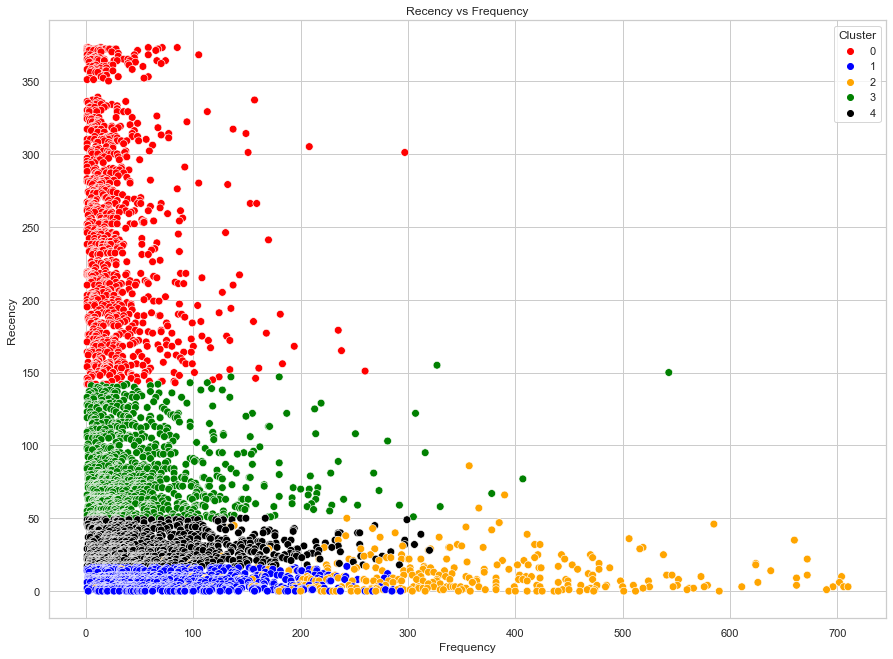

In [39]:
#Scatterplot of the clusters
plt.figure(figsize=(15,11))
sns.scatterplot(x = 'Frequency',y = 'Recency', hue="Cluster",
palette=['red','blue', 'orange', 'green', 'black'], legend='full',data = rfm_ds_final,s = 60 )
plt.xlabel('Frequency')
plt.ylabel('Recency')
plt.title('Recency vs Frequency')
plt.show()

In [40]:
rfm_ds_final[rfm_ds_final['Cluster']==0]

,customerid,last_order_date,Frequency,Amount,Recency,rfm_recency,rfm_frequency,rfm_monetary,rfm_combined,rfm_level,Cluster_Id,Cluster
0,13747.0,01/12/2010 10:37,1,79.60,373,1,1,1,111,Lost,0,0
1,12791.0,01/12/2010 11:27,2,192.60,373,1,1,1,111,Lost,0,0
2,18074.0,01/12/2010 09:53,13,489.60,373,1,1,2,112,Hibernating,0,0
3,16583.0,01/12/2010 12:03,14,233.45,373,1,1,1,111,Lost,0,0
4,17908.0,01/12/2010 11:45,58,243.28,373,1,3,1,131,Lost,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1059,17866.0,20/07/2011 11:07,9,329.65,142,1,1,2,112,Hibernating,0,0
1060,16112.0,19/07/2011 14:28,16,195.74,142,1,1,1,111,Lost,0,0
1061,15713.0,19/07/2011 13:34,19,356.70,142,1,2,2,122,At Risk,0,0
1062,12510.0,20/07/2011 10:15,33,982.57,142,1,2,3,123,At Risk,0,0


In [41]:

rfm_ds_final[rfm_ds_final['Cluster']==2]

,customerid,last_order_date,Frequency,Amount,Recency,rfm_recency,rfm_frequency,rfm_monetary,rfm_combined,rfm_level,Cluster_Id,Cluster
1463,16745.0,30/06/2011 19:13,357,7194.30,86,2,4,4,244,Customers Needing Attention,2,2
1766,12637.0,21/03/2011 12:44,390,6021.90,66,2,4,4,244,Customers Needing Attention,2,2
1976,17509.0,13/10/2011 10:26,366,6115.14,57,2,4,4,244,Customers Needing Attention,2,2
2131,15301.0,28/09/2011 09:43,243,5070.35,50,3,4,4,344,Loyal,2,2
2181,16007.0,23/10/2011 11:05,385,1701.94,47,3,4,4,344,Loyal,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...
4251,16558.0,31/05/2011 10:45,460,8338.49,0,4,4,4,444,Best Customers,2,2
4252,17315.0,31/08/2011 15:49,473,6292.26,0,4,4,4,444,Best Customers,2,2
4253,14730.0,28/03/2011 12:52,501,2005.06,0,4,4,4,444,Best Customers,2,2
4254,15498.0,27/10/2011 16:22,512,13316.40,0,4,4,4,444,Best Customers,2,2


In [42]:
rfm_ds_final[rfm_ds_final['Cluster']==1]

,customerid,last_order_date,Frequency,Amount,Recency,rfm_recency,rfm_frequency,rfm_monetary,rfm_combined,rfm_level,Cluster_Id,Cluster
3192,14030.0,21/11/2011 16:48,243,2360.09,17,4,4,4,444,Best Customers,1,1
3196,14768.0,22/11/2011 12:54,5,192.60,16,4,1,1,411,Promising,1,1
3197,17500.0,22/11/2011 14:25,5,1138.00,16,4,1,3,413,Potential Loyalist,1,1
3198,18249.0,22/11/2011 15:07,8,95.34,16,4,1,1,411,Promising,1,1
3199,17010.0,21/11/2011 14:49,11,195.36,16,4,1,1,411,Promising,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4231,14653.0,30/11/2011 10:14,237,1947.55,0,4,4,4,444,Best Customers,1,1
4234,13471.0,23/10/2011 13:10,260,2531.58,0,4,4,4,444,Best Customers,1,1
4236,15910.0,27/01/2011 11:55,267,1232.18,0,4,4,3,443,Loyal,1,1
4238,16794.0,29/11/2011 12:46,285,1222.71,0,4,4,3,443,Loyal,1,1


In [43]:
rfm_ds_final[rfm_ds_final['Cluster']==3]

,customerid,last_order_date,Frequency,Amount,Recency,rfm_recency,rfm_frequency,rfm_monetary,rfm_combined,rfm_level,Cluster_Id,Cluster
984,16919.0,31/05/2011 15:16,327,2596.45,155,1,4,4,144,At Risk,3,3
1020,17337.0,12/05/2011 20:13,543,2027.87,150,1,4,4,144,At Risk,3,3
1038,17444.0,20/06/2011 09:04,135,2940.04,147,1,4,4,144,At Risk,3,3
1039,14461.0,23/03/2011 12:15,180,2103.06,147,1,4,4,144,At Risk,3,3
1054,12947.0,19/07/2011 10:06,97,1603.99,143,1,4,4,144,At Risk,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...
2123,18252.0,21/06/2011 11:47,98,526.67,50,2,4,2,242,Customers Needing Attention,3,3
2124,14257.0,25/01/2011 10:49,106,3099.72,50,2,4,4,244,Customers Needing Attention,3,3
2125,14776.0,31/01/2011 13:17,117,2538.30,50,2,4,4,244,Customers Needing Attention,3,3
2126,16170.0,28/07/2011 10:14,125,1885.05,50,2,4,4,244,Customers Needing Attention,3,3


In [44]:
rfm_ds_final[rfm_ds_final['Cluster']==4]

,customerid,last_order_date,Frequency,Amount,Recency,rfm_recency,rfm_frequency,rfm_monetary,rfm_combined,rfm_level,Cluster_Id,Cluster
2128,15006.0,19/10/2011 15:08,144,502.09,50,3,4,2,342,Potential Loyalist,4,4
2129,14175.0,21/06/2011 14:29,149,3222.30,50,3,4,4,344,Loyal,4,4
2130,12370.0,19/10/2011 14:51,167,3545.69,50,3,4,4,344,Loyal,4,4
2132,13366.0,20/10/2011 13:37,1,56.16,49,3,1,1,311,Promising,4,4
2133,15286.0,21/10/2011 11:08,3,240.55,49,3,1,1,311,Promising,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...
3187,13862.0,28/09/2011 09:15,139,2209.36,17,3,4,4,344,Loyal,4,4
3188,13246.0,21/11/2011 16:50,141,1987.30,17,3,4,4,344,Loyal,4,4
3189,14482.0,25/10/2011 16:13,144,2068.15,17,3,4,4,344,Loyal,4,4
3190,16607.0,29/03/2011 15:15,172,3347.71,17,3,4,4,344,Loyal,4,4


In [57]:
df = rfm_ds_final